In [20]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.externals import joblib

In [13]:
data_original = pd.read_csv('../data.csv', sep='|')
dasmalwerk = pd.read_csv('../dasmalwerk_data.csv', sep='|')
frames = [data_original, dasmalwerk]
result = pd.concat(frames)

In [14]:
#separate labels
X = result.drop(['Name', 'md5', 'legitimate'], axis=1).values
y = result['legitimate'].values

#feature reduction
fsel = ExtraTreesClassifier().fit(X, y)
model = SelectFromModel(fsel, prefit=True)

X_new = model.transform(X)
nb_features = X_new.shape[1]
indices = np.argsort(fsel.feature_importances_)[::-1][:nb_features]
std = np.std([tree.feature_importances_ for tree in fsel.estimators_], axis=0)
for f in range(nb_features):
    print("%d. feature %s (%f)" % (f + 1, result.columns[2+indices[f]], fsel.feature_importances_[indices[f]]))

1. feature DllCharacteristics (0.129779)
2. feature Subsystem (0.094593)
3. feature SectionsMaxEntropy (0.084348)
4. feature Characteristics (0.080166)
5. feature VersionInformationSize (0.077115)
6. feature Machine (0.077054)
7. feature ResourcesMinEntropy (0.069350)
8. feature ImageBase (0.057220)
9. feature MajorSubsystemVersion (0.050587)
10. feature ResourcesMinSize (0.030760)
11. feature SectionsMeanEntropy (0.028346)
12. feature ResourcesMaxEntropy (0.026951)
13. feature SizeOfOptionalHeader (0.026789)


In [15]:
std

array([  9.49471188e-02,   3.60341212e-02,   1.02905002e-01,
         6.47321046e-03,   1.35438912e-02,   1.47533552e-03,
         3.49259649e-04,   3.98598370e-03,   6.10995290e-03,
         6.17922648e-04,   5.41683623e-04,   5.85816727e-02,
         7.52994701e-03,   3.52935124e-03,   1.88813591e-02,
         1.76864449e-02,   1.25013777e-02,   1.62094756e-03,
         3.34174258e-02,   2.49353248e-03,   1.24772929e-04,
         3.11326970e-03,   1.16398545e-02,   1.26987015e-01,
         1.40332287e-01,   7.81274649e-03,   2.01718214e-03,
         2.32907781e-04,   2.37422272e-04,   3.75913479e-05,
         7.48518006e-05,   5.41586173e-03,   5.08358157e-02,
         3.08477903e-02,   1.27862267e-01,   2.04379377e-03,
         6.06393299e-04,   2.63467530e-04,   1.90180368e-04,
         2.09321481e-03,   1.99750974e-04,   3.20682944e-03,
         3.44372138e-03,   5.44854678e-04,   1.56670881e-03,
         2.17776464e-03,   1.24383845e-02,   1.13136817e-01,
         5.56857303e-02,

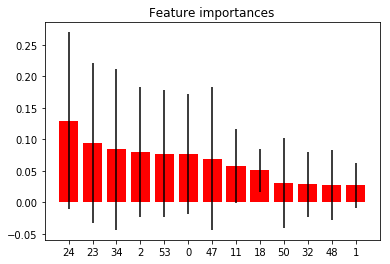

In [16]:
# Plot the feature importances of the forest
%matplotlib inline
plt.figure()
plt.title("Feature importances")
plt.bar(range(nb_features), fsel.feature_importances_[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(nb_features), indices)
plt.xlim([-1,nb_features])
plt.show()

In [17]:
algorithms = {
        "DecisionTree": DecisionTreeClassifier(max_depth=10),
        "RandomForest": RandomForestClassifier(n_estimators=50),
        "GradientBoosting": GradientBoostingClassifier(n_estimators=50),
        "AdaBoost": AdaBoostClassifier(n_estimators=100),
        "GNB": GaussianNB(),
        "MLP": MLPClassifier(hidden_layer_sizes=(12,12,12,12,12,12))
    }

In [24]:
features = []
for f in sorted(np.argsort(fsel.feature_importances_)[::-1][:nb_features]):
    features.append(result.columns[2+f])
features

['Machine',
 'SizeOfOptionalHeader',
 'Characteristics',
 'ImageBase',
 'MajorSubsystemVersion',
 'Subsystem',
 'DllCharacteristics',
 'SectionsMeanEntropy',
 'SectionsMaxEntropy',
 'ResourcesMinEntropy',
 'ResourcesMaxEntropy',
 'ResourcesMinSize',
 'VersionInformationSize']

In [18]:
results = {}
X_train, X_test, y_train, y_test = train_test_split(X_new, y ,test_size=0.25)
print("\nNow testing algorithms")
for algo in algorithms:
    clf = algorithms[algo]
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print("%s : %f %%" % (algo, score*100))
    results[algo] = score

winner = max(results, key=results.get)
print('\nWinner algorithm is %s with a %f %% success' % (winner, results[winner]*100))


Now testing algorithms
RandomForest : 99.373275 %
MLP : 30.005175 %
GradientBoosting : 98.844296 %
GNB : 69.994825 %
DecisionTree : 98.993790 %
AdaBoost : 98.473436 %

Winner algorithm is RandomForest with a 99.373275 % success


In [25]:
joblib.dump(algorithms[winner], '../models/' + winner + '.pkl')
open('../models/features.pkl', 'w').write(pickle.dumps(features))